In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import string

from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation

## Creating transactional from 'features' dataset

In [3]:
df=pd.read_csv('../Ravdess_TRAIN_transformed.csv')
df_copy = df.copy() #for UMAP Projection
df = df.drop(['repetition', 'statement'], axis=1, inplace=False)
df['actor'] = df['actor'].astype(str)

In [4]:
# selecting only one statistics (mfcc, stft, sc...)
selected_columns = df.iloc[:, :5]  # Select the first 7 columns

basic_stat = ['sum', 'max', 'kur', 'skew']
basic_stat_df = df[basic_stat]

mfcc_stat = ['mfcc_sum', 'mfcc_mean', 'mfcc_min', 'mfcc_max', 'mfcc_kur', 'mfcc_skew']
mfcc_df = df[mfcc_stat]
df = (selected_columns.join(mfcc_df)).join(basic_stat_df)

#df = selected_columns.join(df.filter(like='mfcc'))  # Select columns containing 'mfcc' in their name

In [125]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns

Index(['mfcc_sum', 'mfcc_mean', 'mfcc_min', 'mfcc_max', 'mfcc_kur',
       'mfcc_skew', 'sum', 'max', 'kur', 'skew'],
      dtype='object')

### Discretization following the actual distribution

In [5]:
for column in df.select_dtypes(include=np.number):
    # Compute bin edges based on statistical distribution
    n=12
    bin_edges = np.linspace(df[column].min(), df[column].max(), num=n+1)
    
    # Discretize the column into n bins
    df[column] = pd.cut(df[column], bins=bin_edges, labels=False, include_lowest=True)

In [ ]:
# Iterate over each column in the DataFrame
for column in df.columns:
    # Apply the renaming operation using the applymap method
    df[column] = df[column].apply(lambda x: f"{column}_{x}")

### Discretization following a uniformdistribution (qcut)

In [126]:
for column in df.select_dtypes(include=np.number):
    num_bins=12
    df[column] = pd.qcut(df[column], num_bins, labels=False, duplicates='drop')

In [ ]:
# Iterate over each column in the DataFrame
for column in df.columns:
    # Apply the renaming operation using the applymap method
    df[column] = df[column].apply(lambda x: f"{column}_{x}")

In [127]:
df['mfcc_mean'].value_counts()

3     153
7     153
11    153
0     153
2     152
1     152
4     152
5     152
6     152
8     152
10    152
9     152
Name: mfcc_mean, dtype: int64

In [6]:
df.to_csv('ravdess_transactional_01.csv', index=False)

## Creating transactional from time series

In [2]:
Y_train = pd.read_csv("RavdessTimeSeries_Y_train.csv")
X_train = np.load("RavdessTimeSeriesTrim_X_train.npy")

In [3]:
sub_X, sub_Y = X_train, Y_train

In [13]:
#mask
mask_sub = (Y_train["emotional_intensity"]=='strong')#&(Y_train["sex"]=='M')&(Y_train["vocal_channel"]=='speech')
indices_sub = Y_train.index[mask_sub]

#selecting a subset of X
sub_X = X_train[indices_sub]
sub_Y = Y_train.loc[indices_sub]

#sub_X = sub_X[:, 9200:240000]

sub_X.shape

(844, 243200)

In [14]:
%%time
#6 s for 540 records
#noise removing

w = 16
sub_X_cleaned = []

for ts_array in sub_X:
    # Convert ts_array to a pandas Series
    ts_series = pd.Series(ts_array)
    # Calculate ts_det using rolling mean
    ts_det = ((ts_series - ts_series.mean()) / ts_series.std()).rolling(window=w).mean()
    # Convert ts_det back to a NumPy array
    cleaned_array = ts_det.to_numpy()
    sub_X_cleaned.append(cleaned_array)

sub_X = np.array(sub_X_cleaned)

CPU times: total: 10.4 s
Wall time: 10.8 s


In [15]:
%%time
#6 min with 64 symbols and 2000 segments
n_sax_symbols = 32
segments = 2500
sax = SymbolicAggregateApproximation(n_segments=segments, 
                                     alphabet_size_avg=n_sax_symbols,
                                    scale=True)
X_sax = sax.fit_transform(sub_X)

C:\Users\linov\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 844 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


CPU times: total: 9min 38s
Wall time: 9min 39s


In [16]:
reshaped_X_sax = X_sax.reshape(X_sax.shape[0], X_sax.shape[1])
df = pd.DataFrame(reshaped_X_sax)
column_names = [f"Time_{i}" for i in range(X_sax.shape[1])]
df.columns = column_names

In [17]:
n_to_merge = 5

# Calculate the number of columns in the new dataframe
num_columns_new = df.shape[1] // n_to_merge

# Create a new dataframe with the desired dimensions
new_df = pd.DataFrame(index=df.index, columns=range(num_columns_new))

# Iterate over the original dataframe and merge every three consecutive columns
for i in range(num_columns_new):
    start_col = i * n_to_merge
    end_col = start_col + n_to_merge
    new_df[i] = df.iloc[:, start_col:end_col].astype(str).apply('-'.join, axis=1)

df = new_df

In [33]:
#df = df.drop(['emotion'], axis=1, inplace=False)
df = pd.concat([df, sub_Y.reset_index(drop=True)['sex']], axis=1)

In [35]:
df.to_csv('ravdess_transactional.csv', index=False)

# TXMeans

https://github.com/riccotti/TX-Means/blob/master/HowToUse.ipynb

In [20]:
import os, sys, importlib
from os.path import expanduser
from pathlib import Path

# TO DO: Better way to add to PythonPath the package.
home = str(Path.home())

## MODIFY HERE! ##
# This need to point on the folder where you clone the repo (respect to the home...)
Folder_Cloned_In = '/Desktop/' # Change here..
##################

# Full dir name
path_to_lib = home + Folder_Cloned_In

if os.path.isdir(path_to_lib + 'TXMeans'):
    print(f'My Home is: {home}')
    print(f'I cloned in: {path_to_lib}')
    # Add dirs to Python Path 
    sys.path.insert(0, path_to_lib + 'TXMeans/code')
    sys.path.insert(0, path_to_lib + 'TXMeans/code/algorithms')
else:
    print("Can't find Directory.")
    print('For example: you are in')
    print(str(os.getcwd()))

My Home is: C:\Users\linov
I cloned in: C:\Users\linov/Desktop/


In [21]:
import algorithms.txmeans
from algorithms.txmeans import TXmeans # The class (like sklearn)
from algorithms.txmeans import remap_items, count_items, sample_size # Util functions
from algorithms.txmeans import basket_list_to_bitarray, basket_bitarray_to_list # Converting(Reverting) to(from) bitarray
from generators.datamanager import read_uci_data # (Convert the data in nice basket format)
from validation.validation_measures import delta_k, purity, normalized_mutual_info_score # Measure of Validation
from algorithms.util import jaccard_bitarray

import pandas as pd
import numpy as np
import IPython.display as ipd
import datetime

In [36]:
txmeans_model = TXmeans()

class_index = df.shape[1]-1 #supposing the class is in the last column
#class_index = 1
baskets_real_labels, maps = read_uci_data('ravdess_transactional.csv', class_index=class_index)
print( 'ravdess', len(baskets_real_labels))

C:\Users\linov/Desktop/TXMeans/code\generators\datamanager.py:39: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_value = mode(df[k])[0][0]


ravdess 844


In [37]:
# Save baskets and the real labels 
baskets_list = list()
real_labels = list()
count = 0
for basket, label in baskets_real_labels:
    baskets_list.append(basket)
    real_labels.append(label)
    count += 1
    
# Speeding up the Jaccard distance: 
baskets_list, map_newitem_item, map_item_newitem = remap_items(baskets_list)

baskets_list = basket_list_to_bitarray(baskets_list, len(map_newitem_item))

# Get the number of baskets (equal to number of data) 
nbaskets = len(baskets_list)

# Get the number of different item
nitems = count_items(baskets_list)

start_time = datetime.datetime.now()

#fit the model
txmeans_model.fit(baskets_list, nbaskets, nitems)

end_time = datetime.datetime.now()
running_time = end_time - start_time

# Get the label and the clusters 
res = txmeans_model.clustering

print(running_time)

0:10:20.919335


In [38]:
# Number of iteration of the model for the convergence
iter_count = txmeans_model.iter_count
iter_count

3

In [39]:
# Initialize empty predicted labels
pred_labels = [0] * len(real_labels)

# Initialize empty cluster list
baskets_clusters = list()
for label, cluster in enumerate(res):
    # Revert the bitarray transform.
    cluster_list = basket_bitarray_to_list(cluster['cluster']).values()
    for bid, bitarr in cluster['cluster'].items():
        # Labels of every data point
        pred_labels[bid] = label
        # Clusters
        baskets_clusters.append(cluster_list)

In [40]:
# Mesure of "goodness" for clustering algorithm respect to the target attribute
print('delta_k', delta_k(real_labels, pred_labels))
print('normalized_mutual_info_score', normalized_mutual_info_score(real_labels, pred_labels))
print('purity', purity(real_labels, pred_labels))
print(f'Num of Clusters: {len(np.unique(np.array(pred_labels)))}')

delta_k 0
normalized_mutual_info_score 0.1016100659031413
purity 0.6706161137440758
Num of Clusters: 2


## Plotting TXMeans result

In [41]:
from collections import Counter
Counter(pred_labels)

Counter({1: 302, 0: 542})

### Dimensionality Reduction through UMAP

In [24]:
import umap
import plotly.express as px

In [67]:
#only if the rename code was executed before
for column in (df.iloc[:, 5:]).columns:
    df[column] = df[column].str.split('_').str[-1].astype(float)
    
df['emotion'] = df['emotion'].str.split('_').str[-1]
df

AttributeError: Can only use .str accessor with string values!

In [25]:
emotion_mapper = {"neutral":0, "calm":1, "happy":2, "sad":3, "angry":4, "fearful":5, "disgust":6, "surprised":7}
df_copy["emotion"] = df_copy["emotion"].replace(emotion_mapper)

X, y = df_copy.drop(["emotion", "vocal_channel", "emotional_intensity", "actor", "sex", "repetition", "statement"], axis=1), df_copy[["emotion"]].values.flatten()

In [26]:
manifold = umap.UMAP(n_components=2, n_neighbors=45, min_dist=0.3).fit(X, y)
X_reduced = manifold.transform(X)

#plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5, cmap='Spectral');
#plt.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
#plt.title('UMAP projection', fontsize=18);

[Text(0, -5.0, ''),
 Text(0, 0.0, ''),
 Text(0, 5.0, ''),
 Text(0, 10.0, ''),
 Text(0, 15.0, ''),
 Text(0, 20.0, ''),
 Text(0, 25.0, '')]

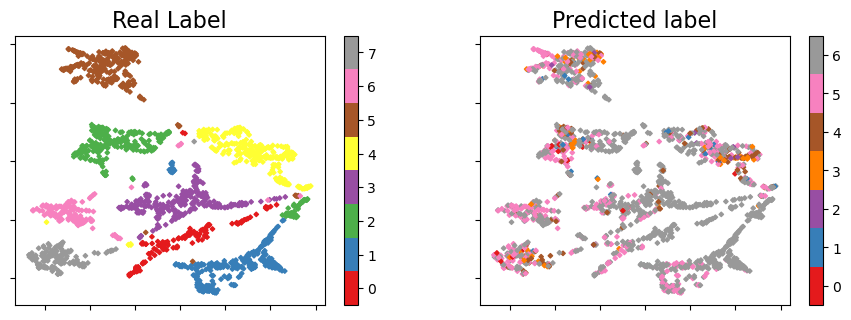

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3.5))

scatter_y = ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=5, cmap='Set1', marker='D')   #c=pred_labels
#ax1.colorbar(boundaries=np.arange(9)-0.5).set_ticks(np.arange(8))
colorbar = plt.colorbar(scatter_y, ax=ax1, boundaries=np.arange(9)-0.5)
colorbar.set_ticks(np.arange(8))
ax1.set_title('Real Label', fontsize=16)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])

scatter_pred = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=pred_labels, s=5, cmap='Set1', marker='D')   #c=pred_labels)
colorbar = plt.colorbar(scatter_pred, ax=ax2, boundaries=np.arange(len(set(pred_labels))+1)-0.5)
colorbar.set_ticks(np.arange(len(set(pred_labels))))
ax2.set_title('Predicted label', fontsize=16)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

In [77]:
colors = pd.Categorical(pred_labels)

fig = px.scatter_3d(df, x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2],
              color=colors, color_continuous_scale='jet')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

In [38]:
import csv

filename = "CLOPE_label.csv"  # Name of the CSV file

# Read the CSV file and save its contents into a list
with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile)
    clope_label = list(reader)[0]
    
clope_label = [int(num) for num in clope_label]

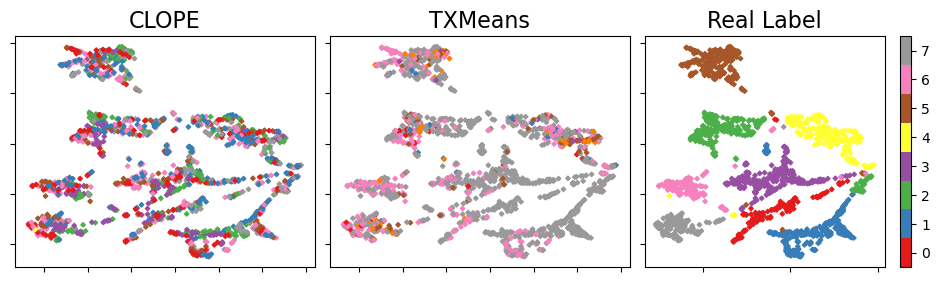

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))

scatter_y = ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clope_label, s=5, cmap='Set1', marker='D')   #c=pred_labels
colorbar = plt.colorbar(scatter_y, ax=ax3, boundaries=np.arange(9)-0.5)
colorbar.set_ticks(np.arange(8))
ax3.set_title('Real Label', fontsize=16)
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])

scatter_pred = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=pred_labels, s=5, cmap='Set1', marker='D')   #c=pred_labels)
ax2.set_title('TXMeans', fontsize=16)
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

scatter_pred = ax3.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=5, cmap='Set1', marker='D')   #c=pred_labels)
ax1.set_title('CLOPE', fontsize=16)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])

plt.subplots_adjust(wspace=0.05)
